# Fake News Detector

The purpose of this project is to create a webapp that gives a fake news rating to articles linked to it by the user. To accomplish this we will need to:
- Create a model that can run in a webapp and converts processed text into a fake news confidence rating.
- Create a system that automatically scrapes the relevant text from any given news article and then processes it into an ingestible form for the model

In [1]:
import kagglehub

#import dataset from kaggle
# path1 = kagglehub.dataset_download("clmentbisaillon/fake-and-real-news-dataset")
# print("Path to dataset files:", path1)

In [2]:
import pandas as pd

#load data
dftrue = pd.read_csv("C:/Users/David/.cache/kagglehub/datasets/clmentbisaillon/fake-and-real-news-dataset/versions/1/true.csv")
dffake = pd.read_csv("C:/Users/David/.cache/kagglehub/datasets/clmentbisaillon/fake-and-real-news-dataset/versions/1/fake.csv")

#add columns to label the real and fake articles
dftrue['label'] = 1
dffake['label'] = 0

#combine
df = pd.concat([dftrue, dffake], ignore_index=True)

df.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


Date range: From 14-Feb-18 to https://fedup.wpengine.com/wp-content/uploads/2015/04/hillarystreetart.jpg
Minimum character count: 1
Maximum character count: 51794
Average character count: 2469.11
Number of rows: 44898


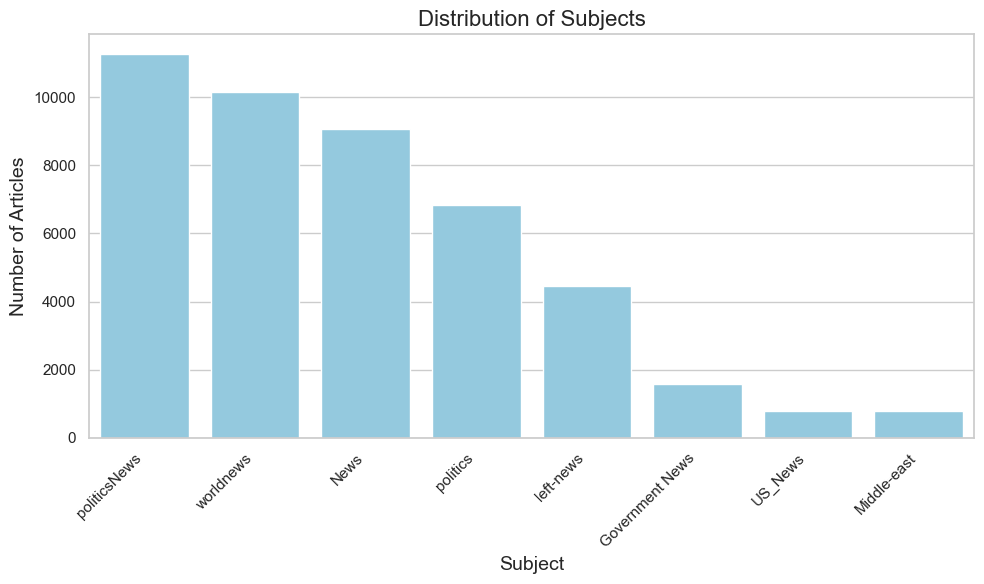

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
def EDA(df):
#find date ranges
    min_date = df['date'].min()
    max_date = df['date'].max()
    print(f"Date range: From {min_date} to {max_date}")

#find article ranges
    text_lengths = df['text'].str.len()
    min_length = text_lengths.min()
    max_length = text_lengths.max()
    avg_length = text_lengths.mean()
    print(f"Minimum character count: {min_length}")
    print(f"Maximum character count: {max_length}")
    print(f"Average character count: {avg_length:.2f}")

    subject_distribution = df['subject'].value_counts()

#find number of rows  
    num_rows = len(df)
    print(f"Number of rows: {num_rows}")
    
# Set the theme for seaborn
    sns.set_theme(style="whitegrid")

# Plot the bar chart using seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(x=subject_distribution.index, y=subject_distribution.values, color='skyblue')

# Add labels and title
    plt.title('Distribution of Subjects', fontsize=16)
    plt.xlabel('Subject', fontsize=14)
    plt.ylabel('Number of Articles', fontsize=14)
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Display the plot
    plt.tight_layout()
    plt.show()

EDA(df)

Date range: From 2016-01-13 00:00:00 to 2017-12-31 00:00:00
Minimum character count: 1000
Maximum character count: 51794
Average character count: 2994.76
Number of rows: 35446


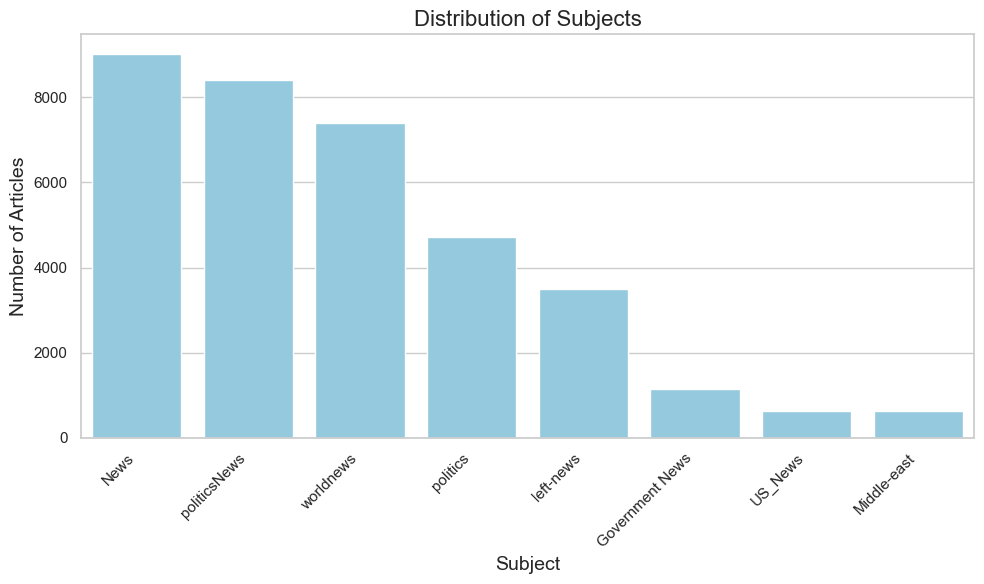

In [4]:
# Convert the 'date' column to datetime, invalid dates will become NaT
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Drop rows where the 'text' column has fewer than 50 characters
df = df[df['text'].str.len() >= 1000]

EDA(df)

Note: you may need to restart the kernel to use updated packages.
